In [77]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack
from wordcloud import WordCloud, ImageColorGenerator #Nube de palabras y colores para las palabras en la nube
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
file_names = ["../input/delitos.csv", "../input/no_delitos_limpio.csv","../input/tweets-delitos-otro_grupo.csv"]

df = pd.concat([pd.read_csv(name, usecols=['Content', 'Delito']) for name in file_names])

# Preprocesamiento

In [59]:
df

,Content,Delito
0,Desde las cámaras de videovigilancia observamo...,1
1,Desde las cámaras de videovigilancia captamos ...,1
2,Desde las cámaras de videovigilancia realizamo...,1
3,Un vehículo reportado como robado fue captado ...,1
4,#Alerta | Miembros de la \r\n@ATM_Transito\r\n...,1
...,...,...
302,Un cuerpo desmembrado y embalado fue encontrad...,1
303,Delincuentes asaltaron en un local de ropa ubi...,1
304,Delincuente fue neutralizado cuando intentó ro...,1
305,Delincuentes destrozaron un negocio porque el ...,1


In [60]:
text = " ".join(df["Content"])
text = text.lower()

In [61]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pengu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pengu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
stops = stopwords.words("spanish")

In [64]:
# Definir la función de preprocesamiento
def preprocessing(text):
    # Inicializar el Snowball Stemmer para español
    stemmer = SnowballStemmer("spanish")
    # Eliminar URLs
    text = re.sub(r'http\S+', '', text)
    # Eliminar menciones
    text = re.sub(r'@\w+', '', text)
    # Eliminar hashtags
    text = re.sub(r'#', '', text)
    # Eliminar caracteres especiales
    text = re.sub(r'[^\w\s]', '', text)
    # Convertir texto a minúsculas
    text = text.lower()
    # Tokenizar el texto
    words = word_tokenize(text)
    # Eliminar stopwords y aplicar stemming
    words = [stemmer.stem(word) for word in words if word not in stopwords.words('spanish')]
    # Unir las palabras procesadas en una oración
    return ' '.join(words)

## ¿Cómo se visualiza el vocabulario empleado en los tweets en un Wordcloud? 

### Sin Preprocesamiento (solo sin stopwords)

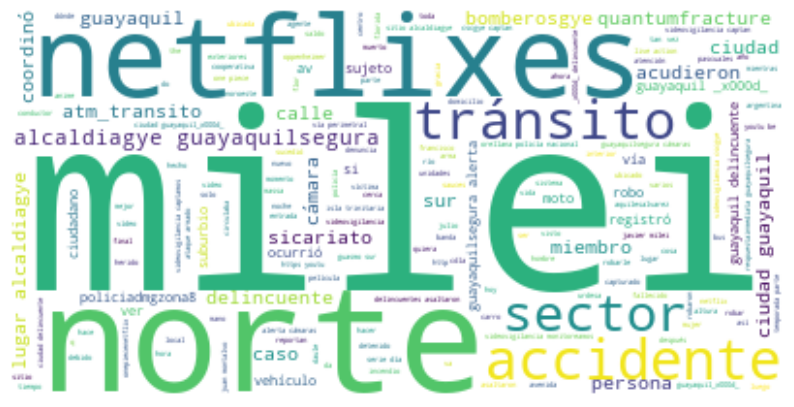

In [65]:
# Generar y mostrar una nube de palabras
wc = WordCloud(stopwords=stops, background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [66]:
text = preprocessing(text)

### Con Preprocesamiento

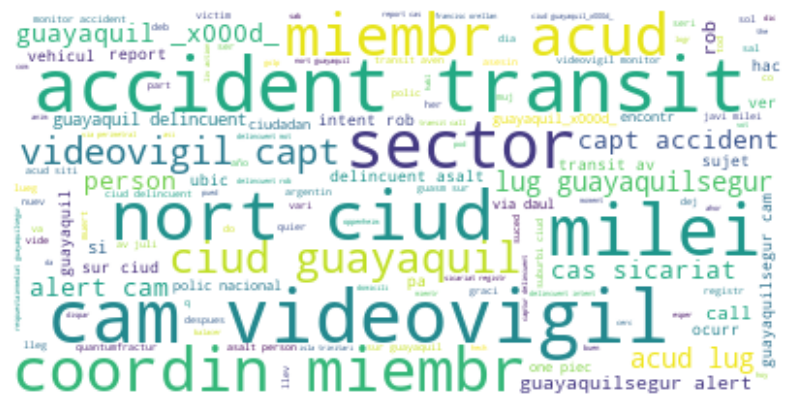

In [67]:
# Generar y mostrar una nueva nube de palabras después del preprocesamiento
wc = WordCloud(stopwords=stops, background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Resto

In [68]:
df['Content'] = df['Content'].apply(preprocessing)

In [69]:
df['Delito'].value_counts()

1    859
0    530
Name: Delito, dtype: int64

In [70]:
# Submuestreo de la clase mayoritaria "Delito" para balancear las clases
dfn = df.loc[df["Delito"] == 0]
dfd = df.loc[df["Delito"] == 1]

In [71]:
dfd = dfd.sample(n=530, random_state=20)

In [72]:
df = pd.concat([dfd, dfn])
df["Delito"].value_counts()

1    530
0    530
Name: Delito, dtype: int64

In [73]:
# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = df['Content']
y = df['Delito']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
# Vectorizar los datos de texto utilizando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [75]:
# Reducción de dimensionalidad mediante PCA
pca = PCA(n_components=500)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [76]:
sum(pca.explained_variance_ratio_)

0.9199722357230712

# Modelo y Resultados

## ¿Cuál es el impacto de la reducción de dimensionalidad a través de PCA en el rendimiento del modelo?

### SIN PCA

In [26]:
# Inicializar y entrenar un clasificador Random Forest
first_clf = RandomForestClassifier(n_estimators=100, random_state=42)
first_clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Realizar predicciones en el conjunto de prueba
y_pred = first_clf.predict(X_test_tfidf)

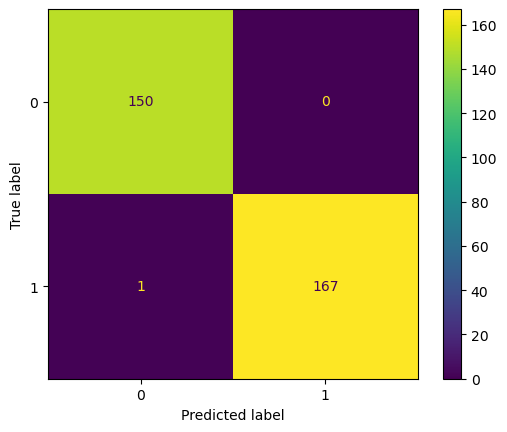

In [29]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=first_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=first_clf.classes_)
disp.plot()
plt.show()

In [31]:
# Reporte de la clasificación
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      0.99      1.00       168

    accuracy                           1.00       318
   macro avg       1.00      1.00      1.00       318
weighted avg       1.00      1.00      1.00       318



Precisión y Recall: Tanto la precisión como el recall para ambas clases son prácticamente perfectos (1.00). Esto significa que el modelo es extremadamente preciso en la clasificación de tweets como "Delito" y "No Delito", y también es capaz de identificar la gran mayoría de los casos verdaderos positivos y verdaderos negativos.

Exactitud: La exactitud general del modelo es del 100%, lo que indica que el modelo clasifica correctamente todos los casos en el conjunto de prueba.

Puntaje F1: El puntaje F1 para ambas clases es igualmente perfecto (1.00), lo que refleja un equilibrio ideal entre precisión y recall.

Estos resultados sugieren que sin PCA, el modelo está altamente ajustado a los datos de entrenamiento y es capaz de hacer predicciones perfectas en el conjunto de prueba. Sin embargo, este alto rendimiento podría ser un indicio de sobreajuste, y es fundamental evaluar cómo se desempeñaría el modelo en datos nuevos y no vistos en un entorno del mundo real.

## CON PCA

In [36]:
# Inicializar y entrenar un clasificador Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test_pca)

# Evaluar el modelo Random Forest
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

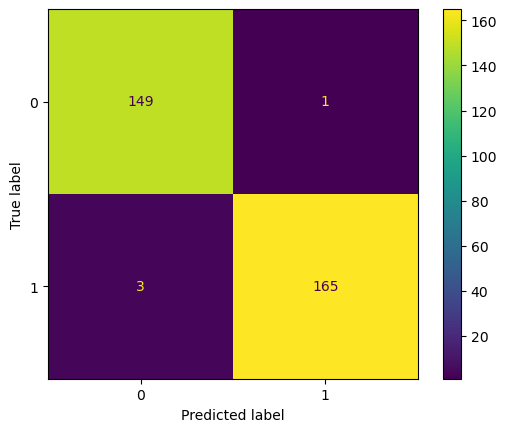

In [38]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

In [39]:
# Reporte de la clasificación
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       150
           1       0.99      0.98      0.99       168

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



Precisión y Recall: La precisión y el recall para ambas clases siguen siendo bastante altos, con valores cercanos a 0.98 y 0.99. Esto indica que el modelo conserva su capacidad de ser preciso y de identificar la gran mayoría de los casos verdaderos positivos y verdaderos negativos.

Exactitud: La exactitud general del modelo es del 99%, lo que aún indica que el modelo clasifica correctamente la gran mayoría de los casos en el conjunto de prueba.

Puntaje F1: El puntaje F1 para ambas clases se sitúa alrededor de 0.99, lo que refleja un equilibrio sólido entre precisión y recall.

En resumen, a pesar de la pequeña reducción en las métricas en comparación con los resultados sin PCA, el modelo todavía demuestra un rendimiento muy sólido y sigue siendo eficaz en la clasificación de tweets como "Delito" y "No Delito". La implementación de PCA ayudó a reducir la dimensionalidad de los datos y, al mismo tiempo, mantuvo un alto nivel de precisión en la clasificación.

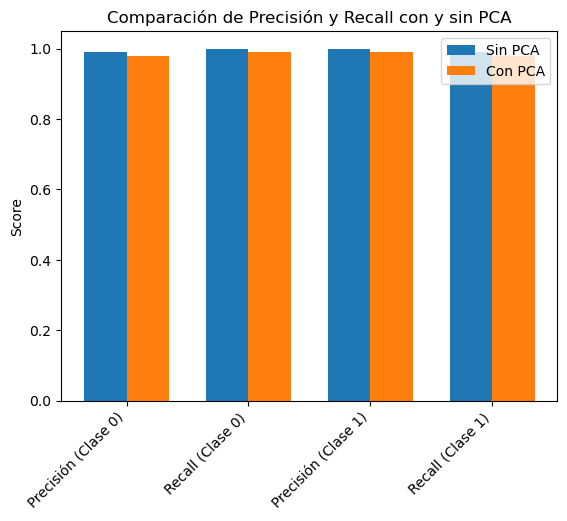

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Precisión y Recall para ambas clases sin PCA
precision_recall_without_pca = [0.99, 1.00, 1.00, 0.99]
classes_without_pca = ['Precisión (Clase 0)', 'Recall (Clase 0)', 'Precisión (Clase 1)', 'Recall (Clase 1)']

# Precisión y Recall para ambas clases con PCA
precision_recall_with_pca = [0.98, 0.99, 0.99, 0.98]

x = np.arange(len(classes_without_pca))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, precision_recall_without_pca, width, label='Sin PCA')
ax.bar(x + width/2, precision_recall_with_pca, width, label='Con PCA')

ax.set_ylabel('Score')
ax.set_title('Comparación de Precisión y Recall con y sin PCA')
ax.set_xticks(x)
ax.set_xticklabels(classes_without_pca, rotation=45, ha="right")
ax.legend()

plt.show()

## ¿Qué palabras o características contribuyen más a la clasificación de tweets como "Delito" o "No Delito" en modelo sin PCA

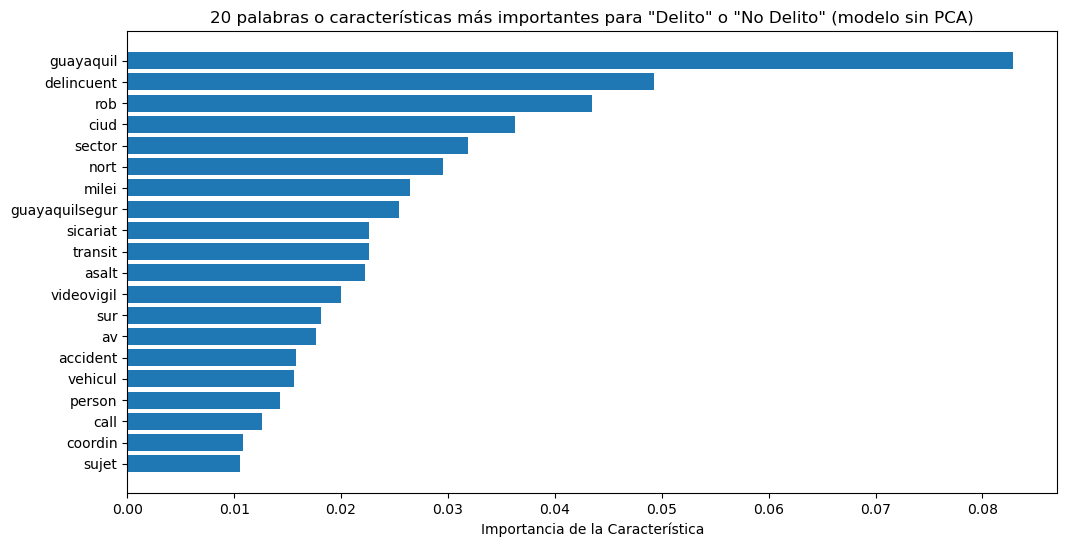

In [50]:
# Obtener los nombres de las características del vectorizador TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Obtener las importancias de las características del modelo RandomForest
feature_importances = first_clf.feature_importances_

# Obtener los índices de las características más importantes ordenadas por importancia descendente
sorted_indices = feature_importances.argsort()[::-1]

# Obtener las N características más importantes y sus importancias
top_n = 20  # Puedes ajustar este valor según la cantidad de características que desees mostrar
top_feature_indices = sorted_indices[:top_n]
top_feature_names = [feature_names[i] for i in top_feature_indices]
top_feature_importances = [feature_importances[i] for i in top_feature_indices]

# Crear un gráfico de barras para visualizar las características más importantes
plt.figure(figsize=(12, 6))
plt.barh(top_feature_names, top_feature_importances)
plt.xlabel('Importancia de la Característica')
plt.title(f'{top_n} palabras o características más importantes para "Delito" o "No Delito" (modelo sin PCA)')
plt.gca().invert_yaxis()
plt.show()